# This study was carried out by İshak Kutlu within the scope of the Central Bank of the Republic of Türkiye specialization qualification thesis titled "Forecasting the Banknote Demand of the Economy with Artificial Intelligence Technologies and Time Series Analysis: A Comparison of Turkey-Wide and Eskişehir Branch Rediscount Region".
# You can review the vocational qualification thesis published in 2023 from the link below.

https://www.tcmb.gov.tr/wps/wcm/connect/TR/TCMB+TR/Main+Menu/Yayinlar/Calismalar/Uzmanlik+Tezleri/

# Pip Install

In [1]:

'''

!pip install tensorflow
!pip install utils
!pip install autopip
!pip install scikit-learn
!pip install base
!pip install openpyxl
!pip install scikit-learn
!pip install pydot


'''


'\n\n!pip install tensorflow\n!pip install utils\n!pip install autopip\n!pip install scikit-learn\n!pip install base\n!pip install openpyxl\n!pip install scikit-learn\n!pip install pydot\n\n\n'

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

import itertools
import calendar
import keras
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import random

import warnings
warnings.filterwarnings("ignore")

# Upload Data and Preprocess

In [3]:
T200 = "T200"
T100 = "T100"
T50 = "T50"
T20 = "T20"
T10 = "T10"
T5 = "T5"
T_Date = "Year"

denomination_name_list = [T200, T100, T50, T20, T10, T5]

#read by default 1st sheet of an excel file
#df = pd.read_excel('Tr_Data_2009.xlsx') #path for my Colab
#df = pd.read_excel('Esk_Data_2009.xlsx') #path for my Colab
#df = pd.read_excel('../input/esk-data-2009/Esk_Data_2009.xlsx', names= ["Year", "T200", "T100", "T50", "T20", "T10", "T5"] , header=0) #path for my Kaggle
df = pd.read_excel('../input/tr-data-2009/Tr_Data_2009.xlsx', names= ["Year", "T200", "T100", "T50", "T20", "T10", "T5"] , header=0) #path for my Kaggle

df = df[:168] 

#convert series to float
df[T200] = df[T200].astype(float)
df[T100] = df[T100].astype(float)
df[T50] = df[T50].astype(float)
df[T20] = df[T20].astype(float)
df[T10] = df[T10].astype(float)
df[T5] = df[T5].astype(float)
#convert series to date
df[T_Date] = pd.to_datetime(df[T_Date])

#split all series by denominations
df200 = df[[T200]]
df100 = df[[T100]]
df50 = df[[T50]]
df20 = df[[T20]]
df10 = df[[T10]]
df5= df[[T5]]
dfdate = df[[T_Date]]


'''
#print(df.head())
#print(df.tail())
#print(df.iloc[0:10])
#print(df.info())
'''


'\n#print(df.head())\n#print(df.tail())\n#print(df.iloc[0:10])\n#print(df.info())\n'

In [4]:

def data_transformation(data):
    
    #Month's name list of the year and convert it to dataframe
    month_list=[]
    counter=0
    for i in range(12):
        counter+=1
        month_list.append(calendar.month_abbr[counter])
        #month_list.append(calendar.month_name[counter])

    df_month=pd.DataFrame(month_list, columns=["Month"]) 
    #df_month.columns =["Month"]
    #return df_month
    
    #twelve-month data ([2012-1, 2012-2... 2012-11, 2012-12], ... , [2022-1, 2022-2, ... 2022-11, 2022-12])
    my_series = data.squeeze()
    my_list=[]
    for i in range(0, len(my_series), 12):
        my_ser=my_series[i:i+12]
        my_df=pd.DataFrame(my_ser)
        my_df.reset_index(drop=True,inplace=True)
        my_list.append(my_df)
     #return my_list
    
    #create matrix format (columns=T100..T100...T100, rows= months)
    counter=0
    df_new=pd.DataFrame(my_list[0])
    for i in range(0, len(my_list)-1):
        counter+=1
        df_new = pd.concat([df_new, my_list[counter]], axis=1)

    df_new = pd.concat([df_new, df_month], axis=1)
    df_new.set_index('Month', inplace=True)
    #df_new.reset_index(drop=True,inplace=True)
    #return df_new
    
    #transpose the matrix format (rows=T100..T100...T100, columns= months)
    df_new=df_new.transpose()
    #return df_new

    #create a year column
    data = pd.concat([dfdate, data], axis=1)
    data['Year'] = data['Year'].dt.strftime('%Y')
    #data.set_index('Year', inplace=True)
    #return data
    
    #make items of the year column unique
    my_series = data["Year"].squeeze()
    year_list=[]
    for i in range(0,len(my_series),12):
    #for i in range(0,len(my_series)):   
        year_list.append(int(my_series[i]))
    #year_list=set(year_list)
    #year_list
    #return year_list
    
    #add unique items of the year column to the matrix and make it index column
    df_year=pd.DataFrame(year_list, columns=["Year"])
    df_new.reset_index(drop=True, inplace=True)
    df_new = pd.concat([df_new, df_year], axis=1)
    df_new.set_index('Year', inplace=True)

    return df_new


In [5]:
#denomination

df_data=df10
T=T10
df_data=round(df_data/1000, 0) #convert package: 1 package consists of 100 banknotes.

#print(df_data.info())

df_matrix=data_transformation(df_data)
df_matrix= df_matrix.transpose()
df_matrix

Year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Jan,50694.0,115768.0,132994.0,139861.0,140929.0,154751.0,167793.0,182755.0,194793.0,206599.0,214627.0,239111.0,264007.0,293640.0
Feb,78470.0,115786.0,132474.0,137313.0,140592.0,153764.0,169377.0,181374.0,194471.0,207367.0,216662.0,242522.0,265219.0,298873.0
Mar,91380.0,115311.0,133301.0,140600.0,143718.0,155162.0,168231.0,181543.0,198754.0,211337.0,220322.0,250750.0,263278.0,303021.0
Apr,102870.0,119188.0,139164.0,140852.0,136236.0,159470.0,173918.0,185275.0,205011.0,216441.0,220794.0,261304.0,273838.0,341371.0
May,106685.0,119616.0,138240.0,140150.0,143365.0,162178.0,176972.0,187275.0,202025.0,220017.0,252311.0,270984.0,285384.0,333202.0
Jun,108726.0,122373.0,141953.0,147345.0,151739.0,165847.0,180374.0,205162.0,225784.0,237844.0,240771.0,267000.0,282103.0,351298.0
Jul,112014.0,128446.0,146980.0,145803.0,155057.0,185655.0,194556.0,208408.0,215361.0,228217.0,234229.0,290224.0,304964.0,381708.0
Aug,113430.0,130206.0,166106.0,159469.0,165937.0,175060.0,188282.0,202521.0,236060.0,247253.0,251622.0,275801.0,293625.0,388653.0
Sep,123787.0,135252.0,154156.0,154184.0,162046.0,177772.0,200392.0,208155.0,219152.0,230926.0,241874.0,271067.0,290026.0,401114.0
Oct,122148.0,139328.0,153517.0,161558.0,166715.0,174637.0,190039.0,201696.0,213217.0,222276.0,240032.0,270245.0,295435.0,408885.0


In [6]:
dates = pd.date_range(start='2009-01', freq='MS', periods=len(df_matrix.columns)*12)
#dates

In [7]:
np_matrix = df_matrix.transpose().values
#np_matrix=df_matrix.transpose().to_numpy()
#np_matrix=np_matrix.transpose()

shape = np_matrix.shape
np_matrix = np_matrix.reshape((shape[0] * shape[1], 1))

np_matrix.shape


(168, 1)

In [8]:
#convert data to panda and indexing
df_data = pd.DataFrame({T: np_matrix[:,0]})
df_data.set_index(dates, inplace=True)

#seperate as test and training data
test_df_data = df_data.loc['2022':'2022']
train_df_data = df_data.loc[: '2021']
train_df_data = train_df_data.round(0)

#print(train_df_data.min())
train_df_data.head(12)

,T10
2009-01-01,50694.0
2009-02-01,78470.0
2009-03-01,91380.0
2009-04-01,102870.0
2009-05-01,106685.0
2009-06-01,108726.0
2009-07-01,112014.0
2009-08-01,113430.0
2009-09-01,123787.0
2009-10-01,122148.0


In [9]:
train_df_data.shape

(156, 1)

In [10]:
first_index= test_df_data.index
first_index[0]

test_df_data.shape
#convert test data to numpy
test_np=test_df_data.to_numpy()
#reduce dimension of test data
test_np = test_np.flatten()
test_np.shape

(12,)

In [11]:
#Scaling data
#scaler = MinMaxScaler(feature_range=(0,1), copy=True)
scaler = StandardScaler()
scaler.fit(train_df_data)


StandardScaler()

In [12]:
def mean_absolute_percentage_error(actual, forecast): 
    actual, forecast = np.array(actual), np.array(forecast)
    #mape=np.mean(np.abs((actual - forecast) / actual)) * 100
    mape=np.mean(np.abs((actual - forecast)) / (abs(actual)+abs(forecast))) * 100 #smape version 1
    #mape=np.mean(np.abs((actual - forecast)) / ((abs(actual)+abs(forecast)))/2) * 100 #smape version 2
    
    return mape
    
def root_mean_squared_error(actual, forecast):
    mse = mean_squared_error(actual, forecast)
    rmse = math.sqrt(mse)
    
    return rmse

In [13]:
def calculate_performance_metrics(actual, forecast):

    mse = mean_squared_error(actual, forecast)
    mae = mean_absolute_error(actual, forecast)
    
    mape = mean_absolute_percentage_error(actual, forecast)
    rmse = root_mean_squared_error(actual, forecast)

    return round(mse, 0), round(mae, 0), round(mape, 2), round(rmse, 0)

In [14]:
def parameter_combinations(parameters):
    return list(itertools.product(*parameters))

In [15]:
def reshape_arrays(X_train, y_train):
    X_train = np.array(X_train)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

In [16]:
def plot_graphs(Type,T,loss, val_loss, actual_global, forecast_values_global):
    my_red=(204/235, 80/235, 85/235)
    my_purple=(123/235, 85/235, 118/235)
    my_turkois=(26/235, 168/235, 212/235)
    my_blue=(51/235, 94/235, 163/235)
    my_dark_blue=(0/235, 23/235, 58/235)
    my_orange=(221/235, 151/235, 47/235)
    my_gray=(172/235, 163/235, 150/235)
    
    
    # plot training and validation error
    limiter=0 #10
    plt.figure(figsize=(5,3))
    plt.plot(loss[limiter:], color=my_blue, alpha=1.0, label='Train') #Don't show first 10 values
    plt.plot(val_loss[limiter:], color=my_purple, alpha=1.0,label='Validation') #Don't show first 10 values
    #plt.axvline(x = global_early_stopping, ymax=val_loss[global_early_stopping], color = my_gray, ls='--', lw=1)
    plt.axvline(x = np.argmin(loss), ymax=val_loss[np.argmin(loss)], color = my_gray, ls='--', lw=1)
    
    print("The Best Epoch: ", np.argmin(loss))
    
    plt.xlabel('Epoch')
    plt.ylabel('Standardized Error')
    plt.legend(loc='upper left', framealpha=0.0)
    plt.title(Type + ": " + T, y=1.1)
    plt.xlim(limiter)
    plt.show()
    
    # plot training, test and forecasting
    plt.figure(figsize=(5,3))
    plt.plot(train_df_data[:len(train_df_data)], color=my_orange, alpha=1.0, label='Train')
    plt.plot(train_predict[:len(train_predict)], color=my_turkois, alpha=1.0, label='Prediction')
    #plt.plot(train_df_data[len(train_df_data)-12:len(train_df_data)], color=my_orange, alpha=1.0, label='Valid_True')
    #plt.plot(train_predict[len(train_predict)-12:len(train_predict)], color=my_turkois, alpha=1.0, label='Valid_Pred')
    plt.plot(actual_global, color=my_red, alpha=1.0, label='Test')
    plt.plot(forecast_values_global, color=my_blue, alpha=1.0, label='Forecasting')
    plt.axvline(x = first_index[0], color = my_gray, ls='--', lw=1)
    plt.xlabel('Date')
    plt.ylabel('Number of Packages')
    plt.legend(loc='upper left', framealpha=0.0)
    plt.title(Type + ": " + T, y=1.1)
    plt.show()
    
    '''
    # plot only test and forecasting
    plt.figure(figsize=(6,3))
    plt.plot(actual_global, color=my_red, alpha=1.0, label='Test')
    plt.plot(forecast_values_global, color=my_blue, alpha=1.0, label='Öngörü')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend(loc='upper left', framealpha=0.0)
    plt.title(Type + ": " + T)
    plt.show()
    '''
    
    print('\n')
    print('==============End==============')
    print('\n')

In [17]:
def create_neural_networks(my_act_funct, input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(Dense(int(hidden_nodes), activation=my_act_funct, input_dim=int(input_nodes)))
    model.add(Dense(int(output_nodes), activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['RootMeanSquaredError'])

    return model

In [18]:
def train_model(model, X_train, y_train, epochs, batch_size):
    global history
    global train_predict
    global global_X_train
    global global_train_predict
    #global global_early_stopping
    
    #model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True) #shuffle=True
    
    early_stopping = EarlyStopping(    
                    monitor="val_loss",
                    min_delta=0.001,
                    patience=50,
                    verbose=1,
                    mode="auto",
                    baseline=None,
                    restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_split=0.07, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True, callbacks=[early_stopping]) #shuffle=True
    
    #for plotting train set prediction
    train_predict = model.predict(X_train)

    try: 
        n,x,y=train_predict.shape
        if n>0 and x>0 and y>0:
            train_predict=train_predict.reshape((n,x*y))
    except ValueError:
        pass
    
    train_predict=scaler.inverse_transform(train_predict)
    train_predict=pd.DataFrame(train_predict)
    new_row=int(len(train_df_data)-len(X_train))
    index_train_df_data=train_df_data.iloc[new_row:]
    train_predict.index = index_train_df_data.index
    
    #for calculating manually smape/mape
    global_X_train=X_train 

    try: 
        n,x,y=global_X_train.shape
        if n>0 and x>0 and y>0:
            global_X_train=global_X_train.reshape((n,x*y))
    except ValueError:
        pass
    
    global_X_train=scaler.inverse_transform(global_X_train)
    global_train_predict=train_predict
    
    #global_early_stopping=early_stopping.stopped_epoch
    #print(global_early_stopping)
    
    return model

# Feed Forward Neural Networks

In [19]:
def preprocess_FNN(data, look_back):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data.shape[0]-look_back):
        x = data[i:look_back+i][::-1]
        y = data[look_back+i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = data[i+1:look_back+i+1][::-1]
    return X_train, y_train, input_seq_for_test

In [20]:
def forecast_FNN(model, input_sequence, future_steps):
        
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0] = np.append(forecasted_value, input_sequence[0][:-1])
    #print(forecasted_values)
    
    return forecasted_values

In [21]:
def FNN(data, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_FNN = preprocess_FNN(data, look_back)
    X_train, y_train = reshape_arrays(X_train, y_train)
    
    model_FNN = create_neural_networks(my_act_funct='selu', input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    model_FNN = train_model(model_FNN, X_train, y_train, epochs, batch_size)

    input_seq_for_test_FNN = np.reshape(input_seq_for_test_FNN, (1, len(input_seq_for_test_FNN)))
    forecasted_values_FNN = forecast_FNN(model_FNN, input_sequence=input_seq_for_test_FNN, future_steps=future_steps)
    
    forecasted_values_FNN = list(scaler.inverse_transform([forecasted_values_FNN])[0])
    
    return model_FNN, forecasted_values_FNN

In [22]:
def get_accuracies_FNN(train_denomination_data, test_denomination_data, parameters, scaler):

    print('\n')
    print('============Summary============')
    print('\n')
    print('FNN')
    print('\n')
    
    combination_of_params = parameter_combinations(parameters)
    information_FNN = []
    iterator = 0
    #print('FNN - Number of combinations: ' + str(len(combination_of_params)))
    
    for param in combination_of_params:
        if len(combination_of_params)>1:
            if (iterator+1) != len(combination_of_params):
                print(iterator+1, end=' -> ')
            else:
                print(iterator+1)
        iterator = iterator+1

        look_back = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]
        
        model_FNN, forecasted_values_FNN = FNN(train_denomination_data, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler)
        
        actual = test_denomination_data.iloc[:future_steps].T
        
        #UPDATE
        actual=actual.to_numpy()
        actual = actual.flatten()
        
        #print(actual)
        
        mse, mae, mape, rmse = calculate_performance_metrics(actual, forecasted_values_FNN)
        
        info = list(param) + [mse, mae, mape, rmse] + forecasted_values_FNN #UPDATE
        information_FNN.append(info)
    
    information_FNN_df = pd.DataFrame(information_FNN)
    indexes = [str(i) for i in list(range(1, future_steps+1))]
    information_FNN_df.columns = ['look_back', 'hidden_nodes', 'output_nodes', 'epochs', 'batch_size', 'future_steps', 'MSE', 'MAE', 'MAPE', 'RMSE'] + indexes #UPDATE
    return information_FNN_df

In [23]:
def get_results_FNN(data_frame, test_denomination_data, flag=False):
    global actual_global
    global forecast_values_global
    global mape_for_parameter_optimization

    optimized_params = data_frame.iloc[data_frame.RMSE.argmin(skipna=True)] #UPDATE
    
    future_steps = optimized_params.future_steps
    forecast_values = optimized_params[-1*int(future_steps):]
    actual = test_denomination_data.iloc[:int(future_steps)]
    forecast_values.index = actual.index
    
    actual_global=actual
    forecast_values_global=forecast_values
    
    '''
    print('\n')
    print('============Summary============')
    print('\n')
    '''
    print('\n')
    
    model = create_neural_networks('selu', optimized_params.look_back, 
                      optimized_params.hidden_nodes, 
                      optimized_params.output_nodes)
    print('Input neurons: ' + str(optimized_params.look_back))
    print('Hidden neurons: ' + str(optimized_params.hidden_nodes))
    print('Output neurons: ' + str(optimized_params.output_nodes))
    
    print('Number of maximum epochs: ' + str(optimized_params.epochs))
    print('Batch size: ' + str(optimized_params.batch_size))
    print('Forecasting steps: ' + str(optimized_params.future_steps))

    new_row=int(len(train_df_data)-len(global_X_train))
    y_true=train_df_data.iloc[new_row:]
    y_true=y_true.to_numpy()
    y_true=y_true.reshape(-1)

    y_hat=global_train_predict
    y_hat=y_hat.to_numpy()
    y_hat=y_hat.reshape(-1)
    
    Train_MSE, Train_MAE, Train_MAPE, Train_RMSE=calculate_performance_metrics(y_true, y_hat)
    
    print('Mean Squared Error(Train_MSE):', round(Train_MSE, 0))
    print('Mean Squared Error(Test_MSE) : ' + str(optimized_params.MSE))
    
    print('Mean Absolute Error(Train_MAE):', round(Train_MAE, 0))
    print('Mean Absolute Error(Test_MAE) : ' + str(optimized_params.MAE))
    
    print('Root Mean Squared Error(Train_RMSE):', round(Train_RMSE, 0))
    print('Root Mean Squared Error(Test_RMSE) : ' + str(optimized_params.RMSE))

    #Train_MAPE=mean_absolute_percentage_error(global_X_train, global_train_predict)
    print('Mean Absolute Percentage Error(Train_SMAPE):', round(Train_MAPE, 2))
    print('Mean Absolute Percentage Error(Test_SMAPE) : ' + str(optimized_params.MAPE))
    
    mape_for_parameter_optimization=optimized_params.MAPE
    
    
    print('\n\n')
    
    #For plotting graph of early stopping
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    #plotting all graphs
    Type = "FNN"
    plot_graphs(Type,T,loss, val_loss, actual_global, forecast_values_global)
    
    
    #return optimized_params

# Time Lagged Neural Networks

In [24]:

def preprocess_TLNN(data, time_lagged_points):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(max(time_lagged_points), data.shape[0]):
        x = [data[i-p] for p in time_lagged_points]
        y = data[i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = [data[i+1-p] for p in time_lagged_points]
    return X_train, y_train, input_seq_for_test


In [25]:

def forecast_TLNN(model, time_lagged_points, last_sequence, future_steps):
    forecasted_values = []
    max_lag = max(time_lagged_points)
    
    for i in range(future_steps):
        input_sequence = [last_sequence[max_lag - p] for p in time_lagged_points]
        
        input_sequence = np.asarray(input_sequence).astype('float32') #UPDATE

        forecasted_value = model.predict(np.reshape(input_sequence, (1, len(input_sequence))))
        forecasted_values.append(forecasted_value[0][0])
        last_sequence = last_sequence[1:] + [forecasted_value[0][0]]

    return forecasted_values


In [26]:

def TLNN(data, time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_TLNN = preprocess_TLNN(data, time_lagged_points)
    X_train, y_train = reshape_arrays(X_train, y_train)
    model_TLNN = create_neural_networks(my_act_funct='selu', input_nodes=len(time_lagged_points), hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    model_TLNN = train_model(model_TLNN, X_train, y_train, epochs, batch_size)

    max_lag = max(time_lagged_points)
    forecasted_values_TLNN = forecast_TLNN(model_TLNN, time_lagged_points, list(data[-max_lag:]), future_steps=future_steps)
    forecasted_values_TLNN = list(scaler.inverse_transform([forecasted_values_TLNN])[0])
    
    return model_TLNN, forecasted_values_TLNN


In [27]:

def get_accuracies_TLNN(train_denomination_data, test_denomination_data, parameters, scaler):
    print('\n')
    print('============Summary============')
    print('\n')
    print('TLNN')
    print('\n')
    
    combination_of_params = parameter_combinations(parameters)
    information_TLNN = []
    iterator = 0
    #print('TLNN - Number of combinations: ' + str(len(combination_of_params)))

    for param in combination_of_params:
        if len(combination_of_params)>1:
            if (iterator+1) != len(combination_of_params):
                print(iterator+1, end=' -> ')
            else:
                print(iterator+1)
        iterator = iterator+1

        time_lagged_points = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]
        
        model_TLNN, forecasted_values_TLNN = TLNN(train_denomination_data, time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler)
        
        actual = test_denomination_data.iloc[:future_steps].T
        
        #UPDATE
        actual=actual.to_numpy()
        actual = actual.flatten()
        
        mse, mae, mape, rmse = calculate_performance_metrics(actual, forecasted_values_TLNN)
        info = list(param) + [mse, mae, mape, rmse] + forecasted_values_TLNN #UPDATE
        information_TLNN.append(info)
    
    information_TLNN_df = pd.DataFrame(information_TLNN)
    indexes = [str(i) for i in list(range(1, future_steps+1))]
    information_TLNN_df.columns = ['look_back_lags', 'hidden_nodes', 'output_nodes', 'epochs', 'batch_size', 'future_steps', 'MSE', 'MAE', 'MAPE', 'RMSE'] + indexes #UPDATE
    
    return information_TLNN_df


In [28]:
def get_results_TLNN(data_frame, test_denomination_data, flag=False):
    global actual_global
    global forecast_values_global
    global mape_for_parameter_optimization
    
    optimized_params = data_frame.iloc[data_frame.RMSE.argmin(skipna=True)] #UPDATE
    
    future_steps = optimized_params.future_steps
    forecast_values = optimized_params[-1*int(future_steps):]
    actual = test_denomination_data.iloc[:int(future_steps)]
    forecast_values.index = actual.index
    
    actual_global=actual
    forecast_values_global=forecast_values
    
    '''
    print('\n')
    print('============Summary============')
    print('\n')
    '''
    print('\n')
    
    model = create_neural_networks('selu', len(optimized_params.look_back_lags), 
                      optimized_params.hidden_nodes, 
                      optimized_params.output_nodes)
    s = ''
    for i in optimized_params.look_back_lags:
        s = s+' '+str(i)
    print('Look back lags (input neurons): ' + s)
    print('Hidden neurons: ' + str(optimized_params.hidden_nodes))
    print('Output neurons: ' + str(optimized_params.output_nodes))
    
    print('Number of maximum epochs: ' + str(optimized_params.epochs))
    print('Batch size: ' + str(optimized_params.batch_size))
    print('Forecasting steps: ' + str(optimized_params.future_steps))
    print('Mean Squared Error(Train_MSE): ' + str(optimized_params.MSE))
    print('Mean Absolute Error(Train_MAE): ' + str(optimized_params.MAE))
    print('Root Mean Squared Error(Train_RMSE): ' + str(optimized_params.RMSE))
    
    new_row=int(len(train_df_data)-len(global_X_train))
    y_true=train_df_data.iloc[new_row:]
    y_true=y_true.to_numpy()
    y_true=y_true.reshape(-1)

    y_hat=global_train_predict
    y_hat=y_hat.to_numpy()
    y_hat=y_hat.reshape(-1)
    
    Train_MSE, Train_MAE, Train_MAPE, Train_RMSE=calculate_performance_metrics(y_true, y_hat)
    
    print('Mean Squared Error(Train_MSE):', round(Train_MSE, 0))
    print('Mean Squared Error(Test_MSE) : ' + str(optimized_params.MSE))
    
    print('Mean Absolute Error(Train_MAE):', round(Train_MAE, 0))
    print('Mean Absolute Error(Test_MAE) : ' + str(optimized_params.MAE))
    
    print('Root Mean Squared Error(Train_RMSE):', round(Train_RMSE, 0))
    print('Root Mean Squared Error(Test_RMSE) : ' + str(optimized_params.RMSE))

    #Train_MAPE=mean_absolute_percentage_error(global_X_train, global_train_predict)
    print('Mean Absolute Percentage Error(Train_SMAPE):', round(Train_MAPE, 2))
    print('Mean Absolute Percentage Error(Test_SMAPE) : ' + str(optimized_params.MAPE))
    
    mape_for_parameter_optimization=optimized_params.MAPE
    
    print('\n\n')
    
    #For plotting graph of early stopping
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    #plotting all graphs
    Type = "TLNN"
    plot_graphs(Type,T,loss, val_loss, actual_global, forecast_values_global)

    #return optimized_params

# Long Short Term Memory

In [29]:

def create_LSTM(my_act_funct, input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(LSTM(hidden_nodes, activation=my_act_funct, input_shape=(1, input_nodes)))
    model.add(Dense((output_nodes), activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['RootMeanSquaredError'])#metrics=['RootMeanSquaredError'])#metrics=['MeanAbsolutePercentageError'])
    return model

In [30]:

def preprocess_LSTM(data, look_back):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data.shape[0]-look_back):
        x = data[i:look_back+i][::-1]
        y = data[look_back+i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = data[i+1:look_back+i+1][::-1]
    return X_train, y_train, input_seq_for_test


In [31]:

def forecast_LSTM(model, input_sequence, future_steps):
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0][0] = np.append(forecasted_value, input_sequence[0][0][:-1])
    return forecasted_values

In [32]:

def implement_LSTM(data, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_LSTM = preprocess_LSTM(data, look_back)
    X_train = np.reshape(X_train, (len(X_train), 1, look_back))

    y_train = np.array(y_train) #UPDATE
    #X_train, y_train = reshape_arrays(X_train, y_train)

    model_LSTM = create_LSTM(my_act_funct='selu', input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    #plot_keras_model(model_LSTM)
    
    model_LSTM = train_model(model_LSTM, X_train, y_train, epochs, batch_size)

    input_seq_for_test_LSTM = np.reshape(input_seq_for_test_LSTM, (1, 1, len(input_seq_for_test_LSTM)))
    forecasted_values_LSTM = forecast_LSTM(model_LSTM, input_sequence=input_seq_for_test_LSTM, future_steps=future_steps)
    
    forecasted_values_LSTM = list(scaler.inverse_transform([forecasted_values_LSTM])[0])
    
    return model_LSTM, forecasted_values_LSTM


In [33]:

def get_accuracies_LSTM(train_denomination_data, test_denomination_data, parameters, scaler):
    print('\n')
    print('============Summary============')
    print('\n')
    print('LSTM')
    print('\n')
    
    combination_of_params = parameter_combinations(parameters)
    information_LSTM = []
    iterator = 0
    #print('LSTM - Number of combinations: ' + str(len(combination_of_params)))
    
    for param in combination_of_params:
        if len(combination_of_params)>1:
            if (iterator+1) != len(combination_of_params):
                print(iterator+1, end=' -> ')
            else:
                print(iterator+1)
        iterator = iterator+1

        input_nodes = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]

        model_LSTM, forecasted_values_LSTM = implement_LSTM(train_denomination_data, input_nodes, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler)
        
        actual = test_denomination_data.iloc[:future_steps].T

        #UPDATE
        actual=actual.to_numpy()
        actual = actual.flatten()
        
        mse, mae, mape, rmse = calculate_performance_metrics(actual, forecasted_values_LSTM)
        
        info = list(param) + [mse, mae, mape, rmse] + forecasted_values_LSTM
        information_LSTM.append(info)

    information_LSTM_df = pd.DataFrame(information_LSTM)
    indexes = [str(i) for i in list(range(1, future_steps+1))]
    information_LSTM_df.columns = ['look_back', 'hidden_nodes', 'output_nodes', 'epochs', 'batch_size', 'future_steps', 'MSE', 'MAE', 'MAPE', 'RMSE'] + indexes
    return information_LSTM_df


In [34]:

def get_results_LSTM(data_frame, test_denomination_data, flag=False):
    global actual_global
    global forecast_values_global
    global mape_for_parameter_optimization

    optimized_params = data_frame.iloc[data_frame.RMSE.argmin(skipna=True)] #UPDATE
    
    future_steps = optimized_params.future_steps
    forecast_values = optimized_params[-1*int(future_steps):]
    actual = test_denomination_data.iloc[:int(future_steps)]
    forecast_values.index = actual.index
    
    actual_global=actual
    forecast_values_global=forecast_values
    
    '''
    print('\n')
    print('============Summary============')
    print('\n')
    '''
    print('\n')

    model = create_neural_networks('selu', optimized_params.look_back, 
                      optimized_params.hidden_nodes, 
                      optimized_params.output_nodes)
    print('Input neurons: ' + str(optimized_params.look_back))
    print('Hidden neurons: ' + str(optimized_params.hidden_nodes))
    print('Output neurons: ' + str(optimized_params.output_nodes))
    
    print('Number of maximum epochs: ' + str(optimized_params.epochs))
    print('Batch size: ' + str(optimized_params.batch_size))
    print('Forecasting steps: ' + str(optimized_params.future_steps))
    print('Mean Squared Error(Train_MSE): ' + str(optimized_params.MSE))
    print('Mean Absolute Error(Train_MAE): ' + str(optimized_params.MAE))
    print('Root Mean Squared Error(Train_RMSE): ' + str(optimized_params.RMSE))
    
    new_row=int(len(train_df_data)-len(global_X_train))
    y_true=train_df_data.iloc[new_row:]
    y_true=y_true.to_numpy()
    y_true=y_true.reshape(-1)

    y_hat=global_train_predict
    y_hat=y_hat.to_numpy()
    y_hat=y_hat.reshape(-1)
    
    Train_MSE, Train_MAE, Train_MAPE, Train_RMSE=calculate_performance_metrics(y_true, y_hat)
    
    print('Mean Squared Error(Train_MSE):', round(Train_MSE, 0))
    print('Mean Squared Error(Test_MSE) : ' + str(optimized_params.MSE))
    
    print('Mean Absolute Error(Train_MAE):', round(Train_MAE, 0))
    print('Mean Absolute Error(Test_MAE) : ' + str(optimized_params.MAE))
    
    print('Root Mean Squared Error(Train_RMSE):', round(Train_RMSE, 0))
    print('Root Mean Squared Error(Test_RMSE) : ' + str(optimized_params.RMSE))

    #Train_MAPE=mean_absolute_percentage_error(global_X_train, global_train_predict)
    print('Mean Absolute Percentage Error(Train_SMAPE):', round(Train_MAPE, 2))
    print('Mean Absolute Percentage Error(Test_SMAPE) : ' + str(optimized_params.MAPE))
    
    mape_for_parameter_optimization=optimized_params.MAPE
    
    
    print('\n\n')
    
    #For plotting graph of early stopping
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    #plotting all graphs
    Type = "LSTM"
    plot_graphs(Type,T,loss, val_loss, actual_global, forecast_values_global)
    
    
    
    #return optimized_params
    

# Run models according to their parameters



============Summary============


FNN


Restoring model weights from the end of the best epoch.
Epoch 00248: early stopping


Input neurons: 12.0
Hidden neurons: 5.0
Output neurons: 1.0
Number of maximum epochs: 500.0
Batch size: 5.0
Forecasting steps: 12.0
Mean Squared Error(Train_MSE): 36639935.0
Mean Squared Error(Test_MSE) : 3348997458.0
Mean Absolute Error(Train_MAE): 4647.0
Mean Absolute Error(Test_MAE) : 46902.0
Root Mean Squared Error(Train_RMSE): 6053.0
Root Mean Squared Error(Test_RMSE) : 57871.0
Mean Absolute Percentage Error(Train_SMAPE): 1.24
Mean Absolute Percentage Error(Test_SMAPE) : 6.55



The Best Epoch:  213


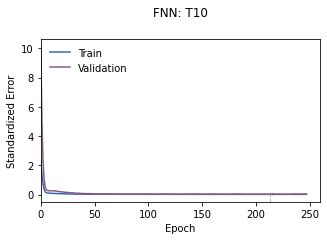

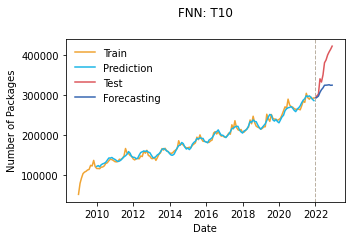



==============End==============




============Summary============


TLNN


Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping


Look back lags (input neurons):  1 2 3 11 12
Hidden neurons: 5
Output neurons: 1
Number of maximum epochs: 500
Batch size: 5
Forecasting steps: 12
Mean Squared Error(Train_MSE): 2392717022.0
Mean Absolute Error(Train_MAE): 40220.0
Root Mean Squared Error(Train_RMSE): 48915.0
Mean Squared Error(Train_MSE): 48024231.0
Mean Squared Error(Test_MSE) : 2392717022.0
Mean Absolute Error(Train_MAE): 4952.0
Mean Absolute Error(Test_MAE) : 40220.0
Root Mean Squared Error(Train_RMSE): 6930.0
Root Mean Squared Error(Test_RMSE) : 48915.0
Mean Absolute Percentage Error(Train_SMAPE): 1.32
Mean Absolute Percentage Error(Test_SMAPE) : 5.55



The Best Epoch:  86


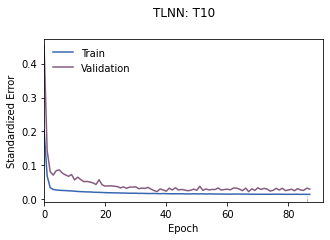

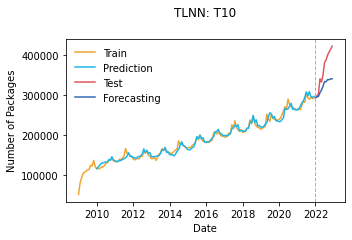



==============End==============




============Summary============


LSTM


Restoring model weights from the end of the best epoch.
Epoch 00253: early stopping


Input neurons: 7.0
Hidden neurons: 5.0
Output neurons: 1.0
Number of maximum epochs: 500.0
Batch size: 5.0
Forecasting steps: 12.0
Mean Squared Error(Train_MSE): 440523888.0
Mean Absolute Error(Train_MAE): 17381.0
Root Mean Squared Error(Train_RMSE): 20989.0
Mean Squared Error(Train_MSE): 46971123.0
Mean Squared Error(Test_MSE) : 440523888.0
Mean Absolute Error(Train_MAE): 5091.0
Mean Absolute Error(Test_MAE) : 17381.0
Root Mean Squared Error(Train_RMSE): 6854.0
Root Mean Squared Error(Test_RMSE) : 20989.0
Mean Absolute Percentage Error(Train_SMAPE): 1.34
Mean Absolute Percentage Error(Test_SMAPE) : 2.39



The Best Epoch:  248


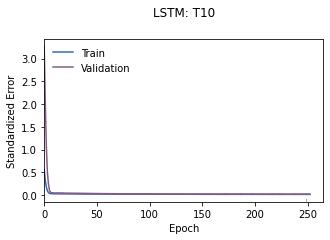

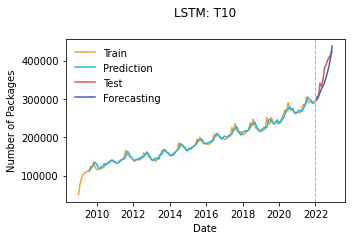



==============End==============




'\n\n\n#seed 25,30\n#seed \nn=1\nk=1\nx=5\ny=5\nfor m in range(k):\n    #y=5\n    #x+=1\n    y+=1\n    for i in range(n):\n        x+=1\n        #y+=1\n\n        #tf.random.set_seed(7) #7/12-4\n        #print("seed: ", x, " / epoch: ", y)\n        #tf.random.set_seed(x)\n        #print("input: ", y)\n        #print("neuron: ", x)\n        \n        a = random.randint(0,30)\n        tf.random.set_seed(a)\n        print("seed: ", a)\n        \n        #LSTM\n        # look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps\n        parameters_LSTM = [[7], [5], [1], [500], [5], [future_steps]] #optimized\n        #tf.set_random_seed(21)\n        tf.random.set_seed(21)\n        information_LSTM_df = get_accuracies_LSTM(train_df_data, test_df_data, parameters_LSTM, scaler)\n        get_results_LSTM(information_LSTM_df, test_df_data)\n\n\n'

In [35]:
future_steps = 12




#10T

#FNN
parameters_FNN = [[12], [5], [1], [500], [5], [future_steps]]
#tf.set_random_seed(2)
tf.random.set_seed(2)
information_FNN_df = get_accuracies_FNN(train_df_data, test_df_data, parameters_FNN, scaler)
get_results_FNN(information_FNN_df, test_df_data)



#10T

#TLNN
parameters_TLNN = [[[1,2,3,11,12]], [5], [1], [500], [5], [future_steps]]
#tf.set_random_seed(0)
tf.random.set_seed(0)
information_TLNN_df = get_accuracies_TLNN(train_df_data, test_df_data, parameters_TLNN, scaler)
get_results_TLNN(information_TLNN_df, test_df_data)



#10T

#LSTM
# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_LSTM = [[7], [5], [1], [500], [5], [future_steps]] #optimized
#tf.set_random_seed(21)
tf.random.set_seed(21)
information_LSTM_df = get_accuracies_LSTM(train_df_data, test_df_data, parameters_LSTM, scaler)
get_results_LSTM(information_LSTM_df, test_df_data)









#______________WORKING AREA________________

'''

mape_for_parameter_optimization = 0
n=10
y=0
for i in range(n):

    #FNN
    parameters_FNN = [[8,9,12], [12], [1], [50], [5], [future_steps]] #optimized
    information_FNN_df = get_accuracies_FNN(train_df_data, test_df_data, parameters_FNN, scaler)
    get_results_FNN(information_FNN_df, test_df_data)

    y += mape_for_parameter_optimization


avg_mape = y/n
print("avg_mape: ", avg_mape)
print("\n")

'''


'''


#seed 25,30
#seed 
n=1
k=1
x=5
y=5
for m in range(k):
    #y=5
    #x+=1
    y+=1
    for i in range(n):
        x+=1
        #y+=1

        #tf.random.set_seed(7) #7/12-4
        #print("seed: ", x, " / epoch: ", y)
        #tf.random.set_seed(x)
        #print("input: ", y)
        #print("neuron: ", x)
        
        a = random.randint(0,30)
        tf.random.set_seed(a)
        print("seed: ", a)
        
        #LSTM
        # look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
        parameters_LSTM = [[7], [5], [1], [500], [5], [future_steps]] #optimized
        #tf.set_random_seed(21)
        tf.random.set_seed(21)
        information_LSTM_df = get_accuracies_LSTM(train_df_data, test_df_data, parameters_LSTM, scaler)
        get_results_LSTM(information_LSTM_df, test_df_data)


'''

